In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from tensorflow_addons.optimizers.utils import fit_bn

from train import *


path = 'jigsaw/t05/20200502_133727_t8b'
gcs = 'hm-eu-w4'
tpu_id = 't8d'


## Configuration
#     path = f'{path}/{time.strftime("%Y%m%d_%H%M%S")}_{tpu_id}'
gcs_path = f'gs://{gcs}/{path}'
checkpoint_path = f"{gcs_path}/best_model.tf"
print('gcs_path:', gcs_path)
# params['gcs_path'] = gcs_path


params = tf.io.gfile.glob(f'{gcs_path}/params*.csv')
print(params)
params = params[0]
params = pd.read_csv(params)

kw_params = params.T[0].to_dict()
print(params.T)
gc.collect()

# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

strategy = setup_tpu(tpu_id)

gcs_path: gs://hm-eu-w4/jigsaw/t05/20200502_133727_t8b
['gs://hm-eu-w4/jigsaw/t05/20200502_133727_t8b/params0.961848.csv']
                                                               0
tpu_id                                                       t8b
max_len                                                      192
seed                                                          20
path                                                  jigsaw/t05
gcs                                                     hm-eu-w4
optimizer                                                   LAMB
batch_size                                                    27
lr                                                   9.68671e-05
mom_min                                                 0.847808
mom_max                                                 0.945613
div_factor                                               722.417
final_div_factor                                         237.209
weight_decay                    

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


REPLICAS:  8


In [3]:
code = f'{"-".join(gcs_path.split("/")[-3:])}'

In [4]:
ds = '../ds'
!rm -rf {ds}
!mkdir {ds}

## Load and Train
with strategy.scope():
    model = build_model(**kw_params)
#     model, preds, sub = train_model(model, strategy, checkpoint_path, **kw_params)

# load best
# latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint_path = f'{gcs_path}/best_model.tf'
with strategy.scope():
    model.load_weights(checkpoint_path)
#     model.save_weights(f'{ds}/xlm-r_{code}_{params["auc"].values[0]}.h5')

!ls -sh {ds}

total 0


In [5]:
# url = f'hmendonca/{code[:40].replace("_", "-")}'
# cmd = f"""
# cat <<EOF > {ds}/dataset-metadata.json
# {{
#   "title": "{code}",
#   "id": "{url}",
#   "licenses": [{{ "name": "CC0-1.0" }}]
# }}
# EOF
# """
# !eval {cmd}
# !cat {ds}/dataset-metadata.json
# # !kaggle datasets version --dir-mode zip -p {path}/ds -m 'again'
# !kaggle datasets create -p {ds}

# url

In [6]:
# !rm -rf {ds}

mean: 0.21181340632114404 ratio: 0.18001316366827555


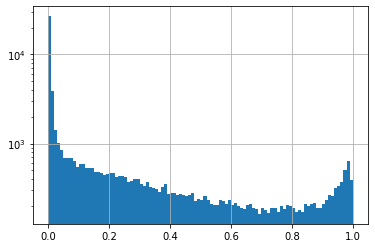

In [7]:
## Load Dataset
comp_ds = '../input/jigsaw-multilingual-toxic-comment-classification'
valid = pd.read_csv(f'{comp_ds}/validation.csv')
#     test = pd.read_csv(f'{comp_ds}/test.csv')
sub = pd.read_csv('../input/jigsaw20-ensemble04-29/submission.csv')

sub.toxic.hist(bins=100, log=True)
print('mean:', sub.toxic.mean(), 'ratio:', (sub.toxic > 0.5).mean())

In [8]:
params.loc[0, "batch_size"]

27

In [9]:
batch_size = 128 #params["batch_size"].values[0] * strategy.num_replicas_in_sync
print('batch_size:', batch_size)

valid_dataset, test_dataset = val_np_dataset(batch_size=batch_size)

# fit_bn(model, valid_dataset)

# preds = model.predict(valid_dataset, verbose=1)
# # sub_y = model.predict(test_dataset, verbose=1)

# valid['pred'] = preds
# valid_auc = roc_auc_score(valid.toxic, valid.pred)
# print('AUC:', valid_auc,
#         'toxic:', valid.toxic.mean(),
#         'pred:', valid.pred.mean(),
#         'ratio:', (valid.pred > 0.5).mean())

batch_size: 128
(8000, 192) (63812, 192) (8000,)


In [10]:
""" load npz datasets """
dataset = '../input/jigsaw20-val-test-ds/jigsaw20_val_ds.npz'
array = np.load(dataset)
x_valid, x_test, y_valid = [array[k] for k in list(array)]
print(x_valid.shape, x_test.shape, y_valid.shape)

# fit_bn(model, x_test, np.ones(len(x_test))*0.5, batch_size=28)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_test, sub.toxic.astype(np.float32)))
    .batch(batch_size)
#     .prefetch(tf.data.experimental.AUTOTUNE)
)

for l in model.layers:
    l.trainable = False
fit_bn(model, test_dataset)

(8000, 192) (63812, 192) (8000,)
Train for 499 steps


/home/henrique/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)
/home/henrique/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


499/499 [==============================] - 613s 1s/step - loss: 0.2774 - accuracy: 3.1342e-05 - auc: 0.9535


In [11]:
preds = model.predict(valid_dataset, verbose=1)
sub_y = model.predict(test_dataset, verbose=1)

499/499 [==============================] - 92s 185ms/step


In [12]:
valid['pred'] = preds
valid.to_csv(f'{gcs_path}/valid_oof_test.csv', index=False)

valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.5)
plt.legend([0, 1])
save_fig('valid_hist_test.png', path, gcs)

valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.34)
plt.legend(valid.lang.unique())
save_fig('valid_toxic_hist_test.png', path, gcs)

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
        'toxic:', valid.toxic.mean(),
        'pred:', valid.pred.mean(),
        'ratio:', (valid.pred > 0.5).mean())

## Submission
sub['toxic'] = sub_y
sub.to_csv(f'{gcs_path}/submission_test.csv', index=False)

sub.toxic.hist(bins=100, log=True)
save_fig('sub_hist_test.png', path, gcs)
print('mean:', sub.toxic.mean(), 'ratio:', (sub.toxic > 0.5).mean())
#     assert sub.toxic.mean() < 0.3

## Save params
params['auc'] = valid_auc
# params.to_csv(f'{gcs_path}/params{valid_auc:04f}.csv', index=False)
print(params.T)

AUC: 0.9624551164270875 toxic: 0.15375 pred: 0.1696925 ratio: 0.14
mean: 0.22621003 ratio: 0.19789381307591047
                                                               0
tpu_id                                                       t8b
max_len                                                      192
seed                                                          20
path                                                  jigsaw/t05
gcs                                                     hm-eu-w4
optimizer                                                   LAMB
batch_size                                                    27
lr                                                   9.68671e-05
mom_min                                                 0.847808
mom_max                                                 0.945613
div_factor                                               722.417
final_div_factor                                         237.209
weight_decay                                

In [13]:
# import pdb; pdb.pm()

/snap/google-cloud-sdk/129/lib/third_party/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
Copying gs://hm-eu-w4/jigsaw/t05/20200502_133727_t8b/sub_hist.png...
Copying gs://hm-eu-w4/jigsaw/t05/20200502_133727_t8b/valid_toxic_hist_test.png...
Copying gs://hm-eu-w4/jigsaw/t05/20200502_133727_t8b/history.png...             
Copying gs://hm-eu-w4/jigsaw/t05/20200502_133727_t8b/sub_hist_test.png...
Copying gs://hm-eu-w4/jigsaw/t05/20200502_133727_t8b/valid_hist.png...
Copying gs://hm-eu-w4/jigsaw/t05/20200502_133727_t8b/valid_toxic_hist.png...    
Copying gs://hm-eu-w4/jigsaw/t05/20200502_133727_t8b/valid_hist_test.png...
/ [7/7 files][ 67.7 KiB/ 67.7 KiB] 100% Done                                    
Operation completed over 7 objects/67.7 KiB.                                     


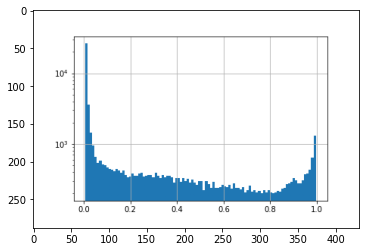

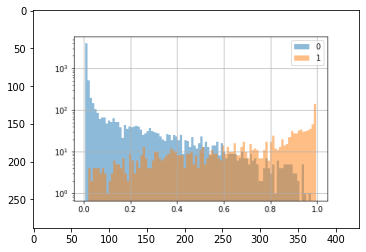

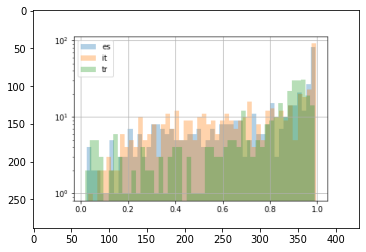

In [14]:
!gsutil -m cp {gcs_path}/*.png .
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('sub_hist.png')
_ = plt.imshow(img)
plt.show()
img = mpimg.imread('valid_hist.png')
_ = plt.imshow(img)
plt.show()
img = mpimg.imread('valid_toxic_hist.png')
_ = plt.imshow(img)

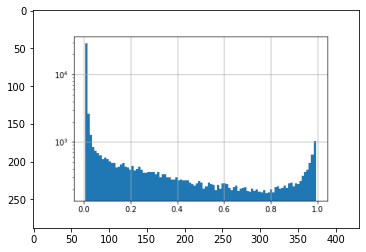

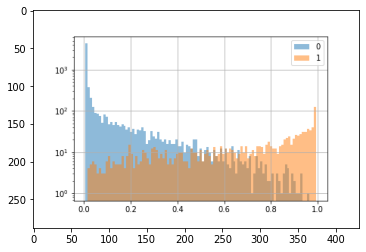

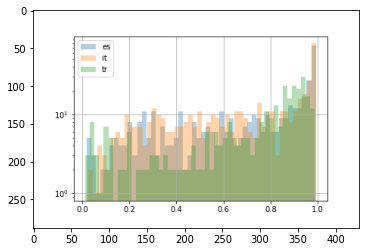

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('sub_hist_test.png')
_ = plt.imshow(img)
plt.show()
img = mpimg.imread('valid_hist_test.png')
_ = plt.imshow(img)
plt.show()
img = mpimg.imread('valid_toxic_hist_test.png')
_ = plt.imshow(img)